In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2  
from tqdm import tqdm

In [38]:
def show_image(images,name,row,col,size1=15,size2=15):
    n = len(images)
    plt.subplots(figsize=(15, 15))

    for i in range(n):
        plt.subplot(row,col,i+1)
        plt.title(name[i])
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')   
    plt.show()

In [39]:
train_path = "data/train"
test_path = "data/test"

In [40]:
train = os.listdir(train_path)
test = os.listdir(test_path)


In [41]:
train_image = [cv2.cvtColor(cv2.imread(os.path.join(train_path, image)), cv2.COLOR_BGR2RGB)  for image in train ]
test_image = [cv2.cvtColor(cv2.imread(os.path.join(test_path, image)), cv2.COLOR_BGR2RGB)  for image in test ]

In [42]:
print("Image size: ", train_image[0].shape)
print("Train images:", len(train_image))
print("Test images:", len(test_image))

Image size:  (490, 680, 3)
Train images: 7500
Test images: 1200


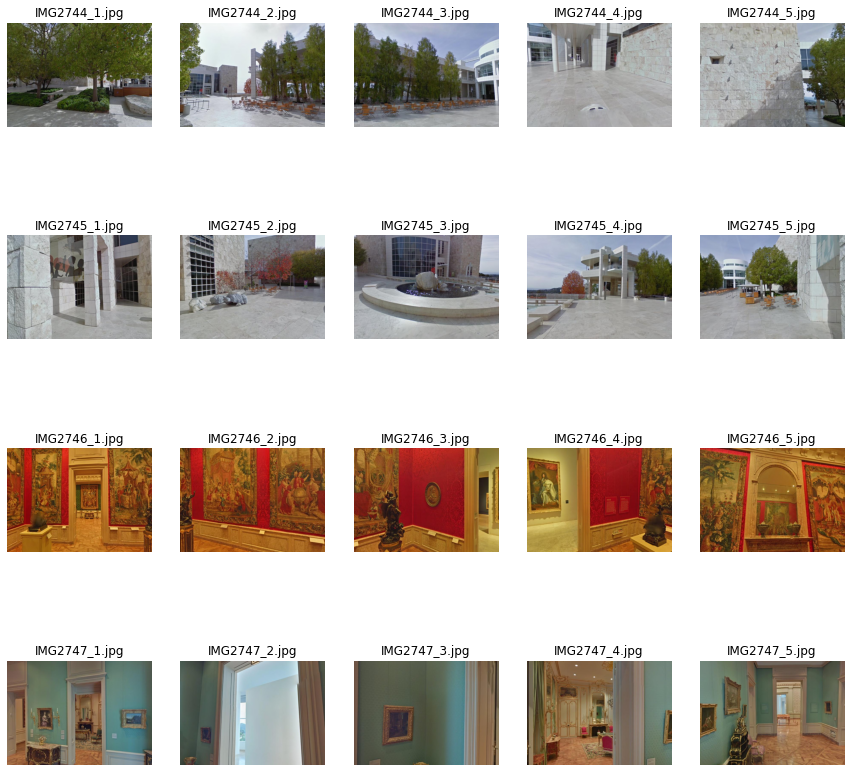

In [43]:
show_image(train_image[:20],train[:20],4,5)

In [44]:
trian_label = pd.read_csv("data/train.csv")
trian_label


,id,x,y
0,IMG2744_1,-9.380678,3.58272
1,IMG2744_2,-9.380678,3.58272
2,IMG2744_3,-9.380678,3.58272
3,IMG2744_4,-9.380678,3.58272
4,IMG2744_5,-9.380678,3.58272
...,...,...,...
7495,IMG4243_1,-4.680678,35.18272
7496,IMG4243_2,-4.680678,35.18272
7497,IMG4243_3,-4.680678,35.18272
7498,IMG4243_4,-4.680678,35.18272


In [45]:
train_cluster = [name[:7] for name in train]
trian_label["cluster"] = train_cluster
trian_label.to_csv("data/with_cluster_train")


In [46]:
grouped_label = trian_label.groupby("cluster")

In [66]:
x_label = []
cluser = []
y_label = []
for i,j in grouped_label:
    #print(i,j["x"])
    cluser.append(i)
    x_label.append(j["x"].iloc[0])
    y_label.append(j["y"].iloc[0])
    #print()

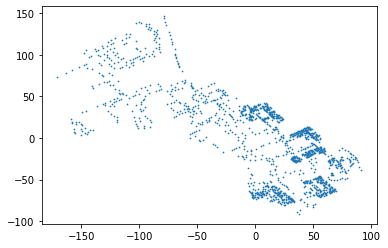

In [68]:
plt.scatter(x_label,y_label,s=0.5)
plt.show()

In [90]:
from sklearn.cluster import KMeans
import numpy as np

Coord = pd.DataFrame(x_label,y_label)

In [88]:
sse = []
for i in tqdm(range(2,20)):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Coord)
    sse.append(kmeans.inertia_)

100%|██████████| 18/18 [00:00<00:00, 20.47it/s]


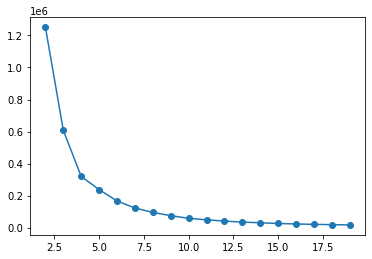

In [89]:
plt.plot(range(2,20),sse,"-o")
plt.show()

In [35]:
["IMG3663","IMG3254"]

['IMG3663', 'IMG3254']

In [49]:
sift = cv2.SIFT_create() 

In [50]:
kp_train = []
des_trian = []
for image in tqdm(train_image):
    kp, des = sift.detectAndCompute(image,None)
    kp_train.append(kp)
    des_trian.append(des)

100%|██████████| 7500/7500 [07:25<00:00, 16.83it/s]


In [51]:
kp_test = []
des_test = []
for image in tqdm(test_image):
    kp, des = sift.detectAndCompute(image,None)
    kp_test.append(kp)
    des_test.append(des)

100%|██████████| 1200/1200 [01:05<00:00, 18.20it/s]


In [55]:
# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [56]:
match_matrix = np.zeros((len(train_image),len(test_image)), dtype=np.ndarray)

In [57]:
flann.knnMatch(des_trian[0],des_test[81],k=2)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\flann\src\miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'cv::flann::buildIndex_'
> type=0
> 

In [60]:
for i in tqdm(range(20)):
    for j in tqdm(range(1200)):
        #match_matrix[i][j] = flann.knnMatch(des_trian[i],des_test[j],k=2)
        try:
            flann.knnMatch(des_trian[i],des_test[j],k=2)
        except:
            print(i,j)

0 81
0 360
0 411
0 828
0 877
0 1023
0 1057
0 1147
1 81
1 360
1 411
1 828
1 877
1 1023
1 1057
1 1147
2 81
2 360
2 411
2 639
2 828
2 877
2 1023
2 1057


In [58]:
matches = flann.knnMatch(des_trian[12],des_trian[13],k=2)

for m,n in matches[:10]:
    print(m.distance,n.distance)

184.94593811035156 235.705322265625
349.4381103515625 367.2056579589844
255.5934295654297 278.3702697753906
300.1532897949219 364.05767822265625
285.2332458496094 292.62091064453125
217.78659057617188 228.6656951904297
119.91664123535156 124.44275665283203
332.5762939453125 338.9100036621094
172.333984375 176.57009887695312
295.3269348144531 330.7022705078125


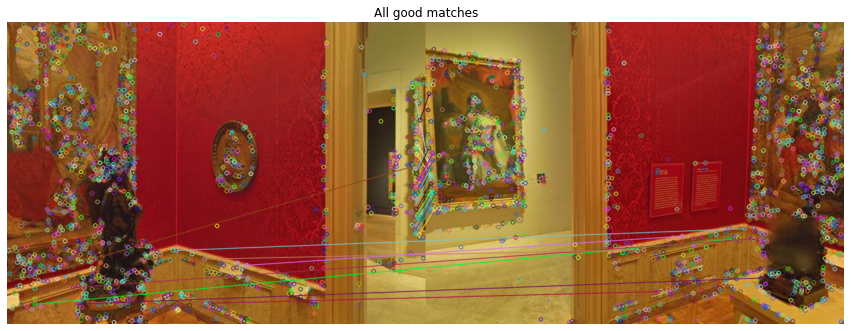

In [59]:
matches = flann.knnMatch(des_trian[12],des_trian[13],k=2)

matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(train_image[12],kp_train[12],train_image[13],kp_train[13],matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()